In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install transformers

     |████████████████████████████████| 2.8 MB 9.3 MB/s 
     |████████████████████████████████| 895 kB 66.1 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 3.3 MB 55.2 MB/s 
     |████████████████████████████████| 636 kB 62.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 241 kB 8.5 MB/s 


In [2]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 94.4MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 212MB/s]
 73% 17.0M/23.4M [00:00<00:00, 28.4MB/s]
100% 23.4M/23.4M [00:00<00:00, 34.4MB/s]
 65% 17.0M/26.3M [00:00<00:00, 33.1MB/s]
100% 26.3M/26.3M [00:00<00:00, 48.9MB/s]


In [5]:
! ls  

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip
sample_data  test.csv.zip		train.csv.zip


In [6]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [7]:
!ls

kaggle.json  sample_submission.csv.zip	test_labels.csv.zip  train.csv.zip
sample_data  test.csv.zip		train.csv


In [8]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import string
import seaborn as sns

In [9]:
df = pd.read_csv("train.csv")[['id', 'comment_text', 'toxic']].sample(1000)

In [10]:
df.sample(3)

,id,comment_text,toxic
144877,13e1198f2be29963,"""\n\nComments at Wikipedia talk:WikiProject Na...",0
12434,20fa20c5151eb406,"""\n\nThanks for correcting. I clicked on """"van...",0
143138,fd7304fac4ee6b67,Davkal?????\n\nNow some say he's doing the obi...,0


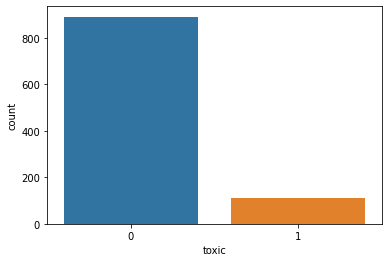

In [11]:
ax = sns.countplot(x="toxic", data=df)

In [12]:
train_df, validation_df = train_test_split(df, test_size = 0.2)
train_df.shape[0], validation_df.shape[0]

(800, 200)

In [102]:
from transformers import BertTokenizer, BertModel
import torch 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_NUMBER_OF_WORDS_IN_SENTENSE = 512
CLS = "[CLS] "
SEP = " [SEP]"
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# model.eval()

# def get_text_hidden_states(text: str):

#   marked_text = "[CLS] " + text + " [SEP]"
#   tokenized_text = tokenizer.tokenize(marked_text)[0: 512]
#   indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
#   segments_ids = [1] * len(tokenized_text)
#   tokens_tensor = torch.tensor([indexed_tokens])
#   segments_tensors = torch.tensor([segments_ids])
#   with torch.no_grad():

#     outputs = model(tokens_tensor, segments_tensors)
#     hidden_states = outputs[2]
    
#     return [torch.mean(hs, dim=1) for hs in hidden_states]
    





Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
train_df[['comment_text_tokens_ids', 'comment_text_segments_ids']] = train_df['comment_text'].progress_apply(text_to_tokens_ids)

100%|██████████| 800/800 [00:01<00:00, 513.25it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [141]:
text = "he went home"
marked_text = CLS + text + SEP
tokenized_text = tokenizer.tokenize(marked_text)[0: MAX_NUMBER_OF_WORDS_IN_SENTENSE]
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

mask1 = [1] * len(indexed_tokens) + [0] * 5
indexed_tokens1= indexed_tokens + [0] * 5

mask2 = [1] * len(indexed_tokens[0:3]) + [0] * 7
indexed_tokens2= indexed_tokens[0:3] + [0] * 7
len(indexed_tokens2), len(indexed_tokens1)

in1 = torch.tensor([indexed_tokens1, indexed_tokens2])
# segments_ids = [1] * len(indexed_tokens)
# segments_tensors = torch.tensor([segments_ids])
mask = torch.tensor([mask1, mask2])
outputs = model(in1, attention_mask = mask)

hidden_states = outputs[2]

hidden_states[-1].shape

ss = torch.IntTensor([5,3])

pp = hidden_states[-1][:, :ss, :]


#torch.mean(hidden_states[-1])
#-0.0128 
# hidden_states[-1][0][-2].shape, len(indexed_tokens), mask

TypeError: ignored

In [92]:
from abc import ABC, abstractmethod
from typing import List 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_fscore_support

class BaseClassifier(ABC):
  
  def __init__(self, bert_model, tokenizer):
    self._bert_model = bert_model
    self._bert_model.eval()
    self._tokenizer = tokenizer

  @abstractmethod
  def fit(self, df: pd.DataFrame):
    pass 

  @abstractmethod
  def predict(self, df: pd.DataFrame):
    pass 
  
  def text_to_tokens_ids(self, text):

    marked_text = CLS + text + SEP
    tokenized_text = self._tokenizer.tokenize(marked_text)[0: MAX_NUMBER_OF_WORDS_IN_SENTENSE]
    indexed_tokens = self._tokenizer.convert_tokens_to_ids(tokenized_text)
    #segments_ids = [1] * len(tokenized_text)

    return indexed_tokens

  def text_to_sentense_embeddingds(self, text: str, embeddings_layer: int):
    indexed_tokens = self.text_to_tokens_ids(text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_ids = [1] * len(indexed_tokens)
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = self._bert_model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]
      
    return torch.mean(hidden_states[embeddings_layer], dim=1).numpy().flatten()
  
  def evaluate(self, df):
    predictions = self.predict(df)
    targets = df['toxic'].tolist()

    precision, recall, fscore, _ = precision_recall_fscore_support(targets, predictions, average='binary')

    return pd.DataFrame([(precision, recall, fscore)], columns = ['precision','recall', 'fscore'])

  
class NearestNeiborClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['toxic'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  

class TorchClassifier(BaseClassifier):
  def __init__(self, bert_model, tokenizer, embeddings_layer, n_neighbors):
    BaseClassifier.__init__(self, bert_model, tokenizer)
    self._embeddings_layer = embeddings_layer
    self._n_neighbors = n_neighbors
    self._model = None

  def fit(self, df: pd.DataFrame):
    
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    y = df['toxic'].tolist()

    self._model = KNeighborsClassifier(n_neighbors = self._n_neighbors)
    self._model.fit(X, y)

  def predict(self, df):
    X = df['comment_text'].progress_apply(lambda text: self.text_to_sentense_embeddingds(text, self._embeddings_layer)).tolist()
    
    return self._model.predict(X)
  
  




In [79]:
# precision_recall_fscore_support([1,0,1,0], [1,1,1,1], average='binary')

(0.5, 1.0, 0.6666666666666666, None)

In [95]:
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True)

model.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nn = NearestNeiborClassifier(model, tokenizer, -1, 3)
nn.fit(train_df)
nn.evaluate(test_size)

100%|██████████| 800/800 [03:22<00:00,  3.94it/s]


100%|██████████| 200/200 [00:46<00:00,  4.27it/s]


,precision,recall,fscore
0,0.785714,0.611111,0.6875


In [ ]:

neigh = KNeighborsClassifier(n_neighbors=3)

X = [x[0].flatten().numpy() for x in train_df['comment_text_layers_embeddingds'].tolist()]
y = train_df['toxic'].tolist()
neigh.fit(X, y)
# len(X), len(y)

np.sum(neigh.predict(X) == y)/len(y)

In [39]:
# text = train_df.iloc[218]['comment_text']

# # pp = get_text_hidden_states(text)
# marked_text = "[CLS] " + text + " [SEP]"
# tokenized_text = tokenizer.tokenize(marked_text)
# indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# segments_ids = [1] * len(tokenized_text)
# tokens_tensor = torch.tensor([indexed_tokens])
# segments_tensors = torch.tensor([segments_ids])
# with torch.no_grad():

#   outputs = model(tokens_tensor, segments_tensors)
#   hidden_states = outputs[2]
# pp = [torch.mean(hs, dim=1) for hs in hidden_states]
# # tokens_tensor.shape, segments_tensors.shape
# len(tokenized_text)

349

In [41]:
train_df['comment_text_layers_embeddingds'] = train_df['comment_text'].progress_apply(get_text_hidden_states)

100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]


In [52]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

X = [x[0].flatten().numpy() for x in train_df['comment_text_layers_embeddingds'].tolist()]
y = train_df['toxic'].tolist()
neigh.fit(X, y)
# len(X), len(y)

np.sum(neigh.predict(X) == y)/len(y)

0.937

In [ ]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df):
        self._df = df


    def __len__(self):
        return len(self._df)
    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array(row['search_term_tokens'])
        product_title = np.array(row['product_title_tokens'])

   

        return row['id'], search_term, product_title, row['relevance_class']
    


In [ ]:
train_df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
37754,115393,138330,Oakland Living Mississippi Patio Service Cart,service cart,3.0,"[101, 9182, 2542, 5900, 19404, 2326, 11122, 102, 0, 0, 0, 0, 0, 0, 0]","[101, 2326, 11122, 102, 0]",0


In [ ]:
BATCH_SIZE = 64
train_data_df = train_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class', 'relevance']]
data_loader = DatasetLoader(train_data_df)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_df_fixed = test_df[(test_df['search_term_tokens'].map(len) > 0) & (test_df['product_title_tokens'].map(len) > 0)]



test_loader = DatasetLoader(test_df_fixed[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']])

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader), len(test_loader)

(74067, 166693)

In [ ]:
train_data_df.sample(1)

,id,product_title_tokens,search_term_tokens,relevance_class,relevance
39466,120409,"[101, 20868, 12173, 2937, 2102, 4293, 3027, 1012, 4658, 2317, 2419, 8164, 2422, 8934, 102]","[101, 4029, 3027, 2419, 102]",2,2.33


,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
35646,52729,113622,AT&amp;T Trimline Telephone With Memory - Black,at,"[amp, <word>, telephon, memori, black]",[],1


In [ ]:
for ids, search_term, product_title, target_relevance_score in test_data_loader:
  break

In [ ]:
for ids, search_term, product_title, target_relevance_score in train_data_loader:
  break



In [ ]:
# from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-uncased",
#                                     output_hidden_states=True)

# bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
#                                          config=config)


In [ ]:
# bb = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_of_labels = 10)
# tt = torch.from_numpy(np.array(tokenize("he weny home for dinner", 10)))

# dd = tokenizer.encode_plus(
#             text,
#             max_length = max_length, 
#             padding = 'max_length',
#             truncation = True, 
#             return_attention_mask = True, 
#             add_special_tokens = True, 
#             )

# x1 = torch.from_numpy(np.ndarray([]]))
# x2 = torch.from_numpy(np.array([dd['attention_mask']]))


# torch.tensor(product_title)
i1 = torch.tensor([[7,8,9],[10,11,12]])
bert_model(i1)['hidden_states'][-1][:, -1,:].shape

torch.Size([2, 768])

In [ ]:
from transformers import BertForSequenceClassification

class RelevanceModel(nn.Module):

  def __init__(self, num_of_classes):
    super(RelevanceModel, self).__init__()
    config = BertConfig.from_pretrained("bert-base-uncased",
                                    output_hidden_states=True)

    self.bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

    for param in self.bert_model.parameters():
      param.requires_grad = False

    self.fc = nn.Linear(768 * 2, num_of_classes)

  def  forward(self, queries, titles):
    encoded_queries = self.bert_model(queries)['hidden_states'][-1][:, -1,:]
    encoded_titles = self.bert_model(titles)['hidden_states'][-1][:, -1,:]

    out = torch.cat((encoded_queries, encoded_titles), 1)

    out = self.fc(out)
    
    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)

In [ ]:

# # for x in model.parameters():
# #   if not x.is_cuda:
# #     print(x) 

# # e1 = EncoderModel(len(vocab)).to(device)
# # r = e1(product_title.to(device), product_title_length)
# output.shape, product_title_length
# #output = r 

# #8
# #out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]

# # output[range(len(output)), product_title_length - 1, :300][0]
# product_title_length
#output[0][14], product_title_length

tensor([14, 12, 10, 15,  8])

In [ ]:
# output[0][13][300:]
# output[:, 0, 300 :].shape, output[:, 0,]


(torch.Size([5, 300]), torch.Size([5, 15, 600]))

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
counts = train_df.groupby("relevance_class").size().reset_index()
#total = np.sum(counts[0].tolist())

# [(row['relevance_class'],  row[0]/total) for (_, row) in counts[['relevance_class', 0]].iterrows()]

total = 0.0
for _, row in counts[['relevance_class', 0]].iterrows():
  total += row[0]
total 
weights = []
print(total)
for _, row in counts[['relevance_class', 0]].iterrows():
  #print(row[0])
  cls = row['relevance_class']
  # print((cls, row[0]))
  sampeples_weight = (row[0] / total)
  required_weight = 1.0/len(counts)

  # print('-----')
  # print(sampeples_weight)
  # print(required_weight)
  x = required_weight/sampeples_weight
  # print(x)

  weight_for_class_a = (1 / row[0]) * total/len(counts)
  

   
  # weight = x * sampeples_weight
  # print(weight)
  # print('-------')

  weights.append((cls, x))



weights = sorted(weights, key = lambda x: x[0])
weights = [w[1] for w in weights]
weights



74067.0


[0.2979064856711916,
 299.8663967611337,
 0.35476099243222536,
 0.37478368230900794,
 0.4857170962030298,
 2.7066325598392105,
 0.8403335602450647,
 1.8953631199140182,
 1424.3653846153848,
 517.951048951049,
 633.0512820512821,
 1139.4923076923078,
 517.951048951049]

In [ ]:
weights

[0.2979064856711916,
 299.8663967611337,
 0.35476099243222536,
 0.37478368230900794,
 0.4857170962030298,
 2.7066325598392105,
 0.8403335602450647,
 1.8953631199140182,
 1424.3653846153848,
 517.951048951049,
 633.0512820512821,
 1139.4923076923078,
 517.951048951049]

In [ ]:
model = RelevanceModel(num_of_classes)
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class_weights=torch.tensor(weights,dtype=torch.float)
criterion = torch.nn.CrossEntropyLoss(weight = class_weights, reduction='sum').to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
class_weights[2].numpy(), weights[2]

(array(0.35470936, dtype=float32), 0.3547093708384031)

In [ ]:

model.train()

for epoc in range(1000):

  running_loss = 0.0
  counter = 0.0

  for ids, search_term, product_title, target_relevance_score  in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).long().to(device)

    optimizer.zero_grad()

    scores = model(search_term, product_title)
    loss = criterion(scores, target_relevance_score)

    

    loss.backward()
    optimizer.step()

    #nn.utils.clip_grad_norm(model.parameters(), 0.5)
    
    running_loss += loss.item()
    counter += search_term.shape[0]
  #   break
  
  # break
  
  print('epoc {} loss {} counter {}'.format(epoc, running_loss/counter, counter))




epoc 0 loss 6.462625524785163 counter 74067.0
epoc 1 loss 5.558418554361422 counter 74067.0
epoc 2 loss 4.873910256250517 counter 74067.0
epoc 3 loss 5.541181676479559 counter 74067.0


In [ ]:
# mse_loss(scores.view(1, -1), target_relevance_score.view(1, -1))
# counter
torch.argmax(scores, dim=1), target_relevance_score

(tensor([3, 6, 3, 4, 0, 2, 7, 6, 2, 0, 6, 2, 7, 4, 0, 2, 2, 2, 7, 6, 2, 0, 6, 6,
         3, 3, 2, 3, 4, 4, 4, 2, 3, 3, 0, 4, 2, 2, 2, 2, 2, 3, 0, 4, 0, 4, 2, 6,
         0, 2, 2, 4, 2, 7, 3, 6, 6, 2, 0, 5, 7, 0, 3, 2], device='cuda:0'),
 tensor([3, 6, 3, 4, 0, 2, 7, 6, 2, 0, 0, 2, 7, 4, 4, 4, 2, 2, 7, 3, 2, 0, 6, 6,
         3, 3, 2, 3, 4, 0, 4, 2, 3, 3, 0, 3, 3, 2, 2, 2, 7, 3, 0, 4, 3, 4, 3, 6,
         0, 2, 2, 4, 2, 7, 3, 6, 6, 2, 0, 5, 7, 0, 3, 2]))

In [ ]:
scores.detach().cpu().numpy() , target_relevance_score.numpy()

(array([[2.4221616],
        [2.4221616],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.4221616],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.4221616],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.4221616],
        [2.4221616],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.4221616],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.390806 ],
        [2.39

In [ ]:
r1, scores.shape

(52, torch.Size([64, 13]))

In [ ]:


model.eval()
test_scores = []
test_ids =[]
tt = []

with torch.no_grad():
  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title, search_term_length,  product_title_length)

    test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
    test_ids.extend(ids.numpy().tolist())
    tt.extend(target_relevance_score.numpy().tolist())

    break
  



In [ ]:
for _ in test_data_loader:
  break

In [ ]:
model.eval()
test_scores = []
test_ids =[]
tt = []
test_data = []
with torch.no_grad():
  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in test_data_loader:
     
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title, search_term_length,  product_title_length)

    vals = torch.argmax(scores, dim=1).flatten().detach().cpu().numpy().tolist()
    ids = ids.numpy().tolist()

    test_data.extend(zip(ids, vals))



    
  

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
Trac

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
pd.DataFrame([(id, cls_to_score[cls]) for (id, cls) in test_data], columns = ["id", "relevance"]).to_csv("test_res.csv", index=  False)

In [ ]:
from google.colab import files
files.download('test_res.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df.sample(1)

,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
107023,159578,161578,Speedi-Products 7 in. 24-Gauge Single Wall Stove Pipe 90 Degree Adjustable Elbow in Black Matte,singel wall stove pipe,"[speedi, product, #, ##, gaug, singl, wall, stove, pipe, ##, degre, adjust, elbow, black, matt]","[singel, wall, stove, pipe]",1
